# 📄 LLM - Detect AI Generated Text

__Designer & Developer:__
- Mobin Nesari 99222107
- Parmida Jabbari 99222028

# 🛠 | Install Libraries 

In [1]:
!pip install -q keras-core==0.1.7 keras_nlp==0.6.3

# 📚 | Import Libraries 

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # "jax" or "tensorflow" or "torch" 

import keras_nlp
import keras_core as keras
import keras_core.backend as K


import torch
import tensorflow as tf

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2024-01-30 22:04:37.450098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 22:04:37.450242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 22:04:37.579409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using PyTorch backend.


/tmp/ipykernel_34/94474038.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


# ⚙️ | Configuration

In [3]:
class CFG:
    verbose = 0 
    wandb = True
    _wandb_kernel = 'awsaf49'  # WandB kernel
    comment = 'LLM-Text-Detection-Deberta'  # Comment description
    preset = "deberta_v3_base_en"  # Name of pretrained models
    sequence_length = 200  # Input sequence length
    device = 'GPU'  # Device
    seed = 42  # Random seed
    num_folds = 5  # Total folds
    selected_folds = [0, 1]  # Folds to train on
    epochs = 3 # Training epochs
    batch_size = 3  # Batch size
    drop_remainder = True  # Drop incomplete batches
    cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM
    scheduler = 'cosine'  # Learning rate scheduler
    class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
    num_classes = len(class_names)  # Number of classes
    class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
    label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
    name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
keras.utils.set_random_seed(CFG.seed)

# 💾 | Hardware
Following codes automatically detects hardware (TPU or GPU). 

In [5]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

        # instantiate a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [6]:
# Initialize GPU/TPU/TPU-VM
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  1


# 📁 | Dataset Path 

In [7]:
BASE_PATH = '/kaggle/input/llm-detect-ai-generated-text'

## Train Data

# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


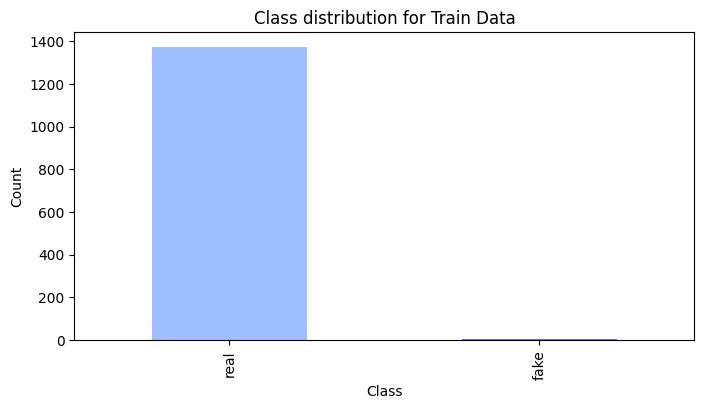

In [8]:
df = pd.read_csv(f'{BASE_PATH}/train_essays.csv')
df['label'] = df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)

print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

plt.figure(figsize=(8, 4))
df.name.value_counts().plot.bar(color=[cmap(0.3), cmap(0.1), cmap(0.8), cmap(0.5), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Data")
plt.show()


As you can see, dataset is highly unbalanced. Due to this fact we should use other datasets.

## External Datasets

Due to unbalanced data, we enhanced our data with two other datasets

* [Proper Train Dataset](https://www.kaggle.com/datasets/thedrcat/daigt-proper-train-dataset/) @thedrcat
* [ArguGPT](https://www.kaggle.com/datasets/alejopaullier/argugpt) @alejopaullier


# External Data: 28,210
# Sample:


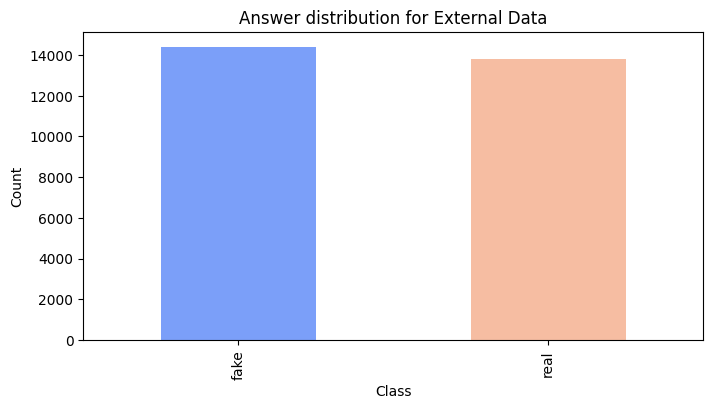

In [9]:
ext_df1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
ext_df2 = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]

ext_df2.rename(columns={'model':'source'}, inplace=True)
ext_df2['label'] = 1

ext_df = pd.concat([
    ext_df1[ext_df1.source=='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source!='persuade_corpus'],
])

ext_df['name'] = ext_df.label.map(CFG.label2name)

print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

plt.figure(figsize=(8, 4))
ext_df.name.value_counts().plot.bar(color=[cmap(0.2), cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()

## Combine External and Train Data

In [10]:
df = ext_df.copy().reset_index(drop=True)
display(df.head())

,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


# 🔪 | Data Split


In [11]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=CFG.seed)

df = df.reset_index(drop=True)

df['stratify'] = df.label.astype(str)+df.source.astype(str)

df["fold"] = -1 

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_idx, 'fold'] = fold

df.groupby(["fold", "name", "source"]).size()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

# 🧼 | Preprocessing

- The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

- Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

In [12]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset,
    sequence_length=CFG.sequence_length,
)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
inp = preprocessor(df.text.iloc[0])

for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : torch.Size([200])
padding_mask : torch.Size([200])


This function is used to preprocess our data and map them into (text, label)

In [14]:
def preprocess_fn(text, label=None):
    text = preprocessor(text)  # Preprocess text
    return (text, label) if label is not None else text  # Return processed text and label if available

# 🎒 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

In [15]:
def build_dataset(texts, labels=None, batch_size=32,
                  cache=False, drop_remainder=True,
                  repeat=False, shuffle=1024):
    AUTO = tf.data.AUTOTUNE  # AUTOTUNE option
    slices = (texts,) if labels is None else (texts, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    ds = ds.repeat() if repeat else ds
    opt = tf.data.Options()
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Fetch Train/Valid Dataset

The function below generates the training and validation datasets for a given fold.

In [16]:
def get_datasets(fold):
    train_df = df[df.fold!=fold].sample(frac=1)
        
    train_texts = train_df.text.tolist()
    train_labels = train_df.label.tolist()
    
    train_ds = build_dataset(train_texts, train_labels,
                             batch_size=CFG.batch_size*CFG.replicas, cache=CFG.cache,
                             shuffle=True, drop_remainder=True, repeat=True)

    valid_df = df[df.fold==fold].sample(frac=1)
    valid_texts = valid_df.text.tolist()
    valid_labels = valid_df.label.tolist()
    
    valid_ds = build_dataset(valid_texts, valid_labels,
                             batch_size=min(CFG.batch_size*CFG.replicas, len(valid_df)), cache=CFG.cache,
                             shuffle=False, drop_remainder=True, repeat=False)
    
    return (train_ds, train_df), (valid_ds, valid_df)

# 🏋️ | WANDB

To monitor the training of my text-based model, I'll make use of **Weights & Biases**. Weights & Biases (W&B) is an MLOps platform that offers experiment tracking, dataset versioning, and model management functionalities, aiding in efficient model development.

In [17]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = "8b38ad07ebfe1142567860f66b61ac7cd505ba92"
    wandb.login(key=api_key)
    anonymous = None
    print('Done')
except:
    anonymous = 'must'
    wandb.login(anonymous=anonymous, relogin=True)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Done


In [18]:
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold": int(fold)})
    run = wandb.init(project="LLM Detection",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]

# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

In [19]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6 * batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1, 0, 0.75
    
    def lrfn(epoch):
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

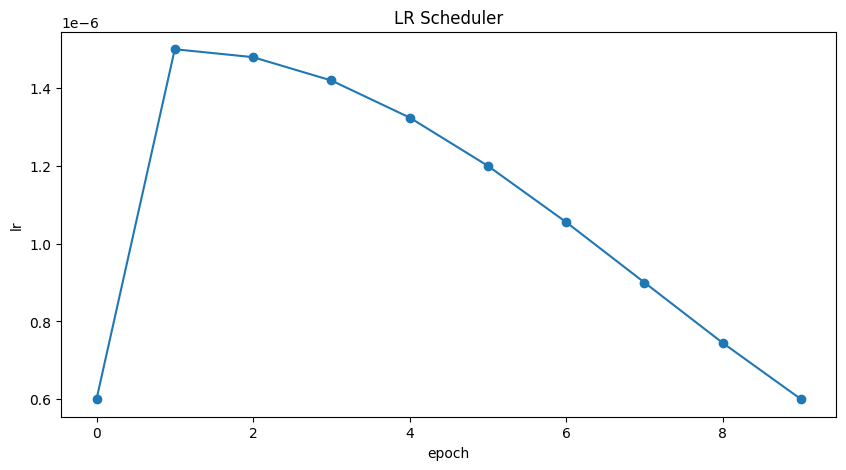

In [20]:
get_lr_callback(CFG.batch_size*CFG.replicas, plot=True)

# ☎️ | Callbacks

The function below will gather all the training callbacks, such as `lr_scheduler`, `model_checkpoint`, `wandb_logger`, and etc.

In [21]:
def get_callbacks(fold):
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                              monitor='val_auc',
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='max')
    callbacks.extend([lr_cb, ckpt_cb])

    if CFG.wandb:
        wb_cbs = get_wb_callbacks(fold)
        callbacks.extend(wb_cbs) 
        
    return callbacks

# 🤖 | Model



In [22]:
def build_model():
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
        CFG.preset,
        preprocessor=None,
        num_classes=1
    )
    inputs = classifier.input
    logits = classifier(inputs)
        
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.AdamW(5e-6),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[
            keras.metrics.AUC(name="auc"),
        ],
        jit_compile=True
    )
    return model

In [23]:
model = build_model()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


/opt/conda/lib/python3.10/site-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

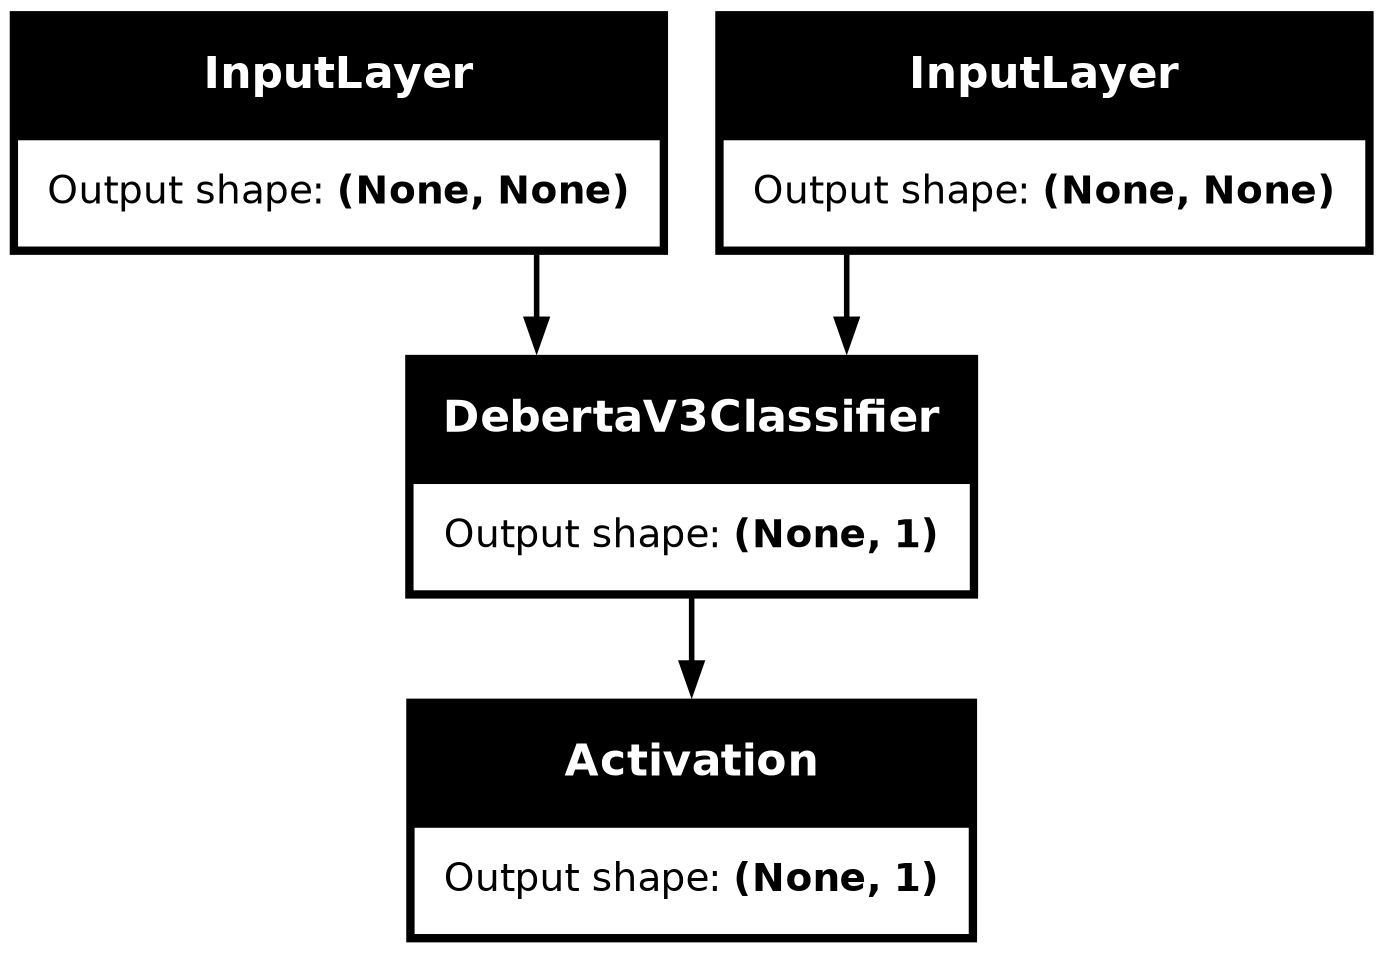

In [25]:
keras.utils.plot_model(model, show_shapes=True)

# 🏃 | Training

In [26]:
for fold in CFG.selected_folds:
    if CFG.wandb:
        run = wandb_init(fold)

    (train_ds, train_df), (valid_ds, valid_df) = get_datasets(fold)
    callbacks = get_callbacks(fold)

    print('#' * 50)
    print(f'\tFold: {fold + 1} | Model: {CFG.preset}\n\tBatch Size: {CFG.batch_size * CFG.replicas} | Scheduler: {CFG.scheduler}')
    print(f'\tNum Train: {len(train_df)} | Num Valid: {len(valid_df)}')
    print('#' * 50)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()

    history = model.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),
    )
    
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]

    print(f'\n{"=" * 17} FOLD {fold} RESULTS {"=" * 17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST AUC   : {best_auc:.3f}\n>>>> BEST Epoch : {best_epoch}')
    print('=' * 50)
    
    if CFG.wandb:
        log_wandb()
        wandb.run.finish()
    print("\n\n")

wandb: Currently logged in as: mobinnesari81. Use `wandb login --relogin` to force relogin


##################################################
	Fold: 1 | Model: deberta_v3_base_en
	Batch Size: 3 | Scheduler: cosine
	Num Train: 22568 | Num Valid: 5642
##################################################


/opt/conda/lib/python3.10/site-packages/keras_core/src/trainers/trainer.py:166: UserWarning: `jit_compile` is not yet enabled for the PyTorch backend. Proceeding with `jit_compile=False`.
  warnings.warn(


Epoch 1/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.9348 - loss: 0.2949

wandb: ERROR Unable to log learning rate.


7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1877s 250ms/step - auc: 0.9348 - loss: 0.2949 - val_auc: 0.9971 - val_loss: 0.1141 - learning_rate: 6.0000e-07
Epoch 2/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 1864s 248ms/step - auc: 0.9981 - loss: 0.0803 - val_auc: 0.9969 - val_loss: 0.1275 - learning_rate: 1.5000e-06
Epoch 3/3
7522/7522 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - auc: 0.9986 - loss: 0.0712

KeyboardInterrupt: 

# 🧪 | Prediction

In [27]:
# Make predictions using the trained model on last validation data
predictions = model.predict(
    valid_ds,
    batch_size=min(CFG.batch_size * CFG.replicas * 2, len(valid_df)), # max batch size = valid size
    verbose=1
)

1880/1880 ━━━━━━━━━━━━━━━━━━━━ 170s 90ms/step


In [28]:
# Format predictions and true answers
pred_answers = (predictions > 0.5).astype(int).squeeze()
true_answers = valid_df.label.values

# Check 5 Predictions
print("# Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text  = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f"❓ Text {i+1}:\n{text[:100]} .... {text[-100:]}\n")
    print(f"✅ True: {true_answer}\n")
    print(f"🤖 Predicted: {pred_answer}\n")
    print("-"*90, "\n")

# Predictions

❓ Text 1:
 Dear Principal,

I believe that students should not be allowed to bring their cell phones to school .... that cell phones be banned in school to help students improve their grades and academic performance.

✅ True: fake

🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

❓ Text 2:
I feel that working with a partner is more beneficial to students. Working with partners gets studen .... at's why it's so beneficial for students to work with partners on projects and other big classworks.

✅ True: real

🤖 Predicted: real

------------------------------------------------------------------------------------------ 

❓ Text 3:
Many people are unaware of the financial benefits of taking an art class. People who study art in co .... class can be beneficial to one's financial bottom line through various methods of generating income.

✅ True: fake

🤖 Predicted: fake

----------------------------------------------